# **Instrument to Instrument (ITI) translation: SOHO/EIT-to-SDO/AIA**


## Read The Docs
For more information about the tool and background of the individual case studies see:

[iti-documentation.rtfd.io](https://iti-documentation.readthedocs.io/en/latest/)

For the translation of SOHO/EIT observations we make use of the multi-channel representation and translate all four EUV channels simultaneous including the magnetogram. For this application we use half of the SDO resolution as reference for our enchancement.

## Installation

In [1]:
import os
!pip install git+https://github.com/spaceml-org/InstrumentToInstrument.git@development
!pip install lightning
!pip install sunpy_soar
!pip install sunpy

  Cloning https://github.com/spaceml-org/InstrumentToInstrument.git (to revision development) to /private/var/folders/tj/7h3lqn950sv5k36g1yyl4vkr0000gn/T/pip-req-build-mhga8u_n
  Running command git clone --filter=blob:none --quiet https://github.com/spaceml-org/InstrumentToInstrument.git /private/var/folders/tj/7h3lqn950sv5k36g1yyl4vkr0000gn/T/pip-req-build-mhga8u_n
  Running command git checkout -b development --track origin/development
  Switched to a new branch 'development'
  Branch 'development' set up to track remote branch 'development' from 'origin'.
  Resolved https://github.com/spaceml-org/InstrumentToInstrument.git to commit b083c705d463997caebf2df663d8774cbe569eda
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.2.1 -> 24.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1

## Imports

In [23]:
from iti.translate import *
import glob
from matplotlib.colors import Normalize
from iti.evaluation.util import download_gcp_bucket
from datetime import datetime
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.coordinates import SkyCoord
import warnings
warnings.filterwarnings('ignore')

base_path = os.getcwd()

## Download data

SOHO and EIT files requires a pre-processing that is only available in SSWIDL. We provide a sample observation from each Instrument. If you want to make use of custom files, use the prep routines and upload your files.

We provide a publicly available dataset which allows the users to play around with a subset of the data available without downloading the entire database.

This dataset contains ``.fits`` files from **PROBA2/SWAP**, **SDO/AIA**, **Solar Orbiter/EUI (FSI and HRI)**, **SOHO/EIT** and **STEREO/EUVI**.

In addition 3 trained models are stored with:
1. PROBA2/SWAP to SDO/AIA
2. Solar Orbiter/EUI FSI to SDO/AIA and
3. SDO/AIA to Solar Orbiter/EUI HRI

to perform the translation.  

In [16]:
download_gcp_bucket('iti-dataset', base_path+'/iti-testset')

Failed to download configs/ due to exception: [Errno 21] Is a directory: '/Users/christophschirninger/PycharmProjects/ITI/examplesiti-testset/configs/'
Downloaded configs/proba2_to_sdo_colab.yaml to /Users/christophschirninger/PycharmProjects/ITI/examplesiti-testsetconfigs/proba2_to_sdo_colab.yaml.
Failed to download models/ due to exception: [Errno 21] Is a directory: '/Users/christophschirninger/PycharmProjects/ITI/examplesiti-testset/models/'
Downloaded models/aia_to_hri_v0_1.pt to /Users/christophschirninger/PycharmProjects/ITI/examplesiti-testsetmodels/aia_to_hri_v0_1.pt.
Downloaded models/fsi_to_aia_v0_3.pt to /Users/christophschirninger/PycharmProjects/ITI/examplesiti-testsetmodels/fsi_to_aia_v0_3.pt.
Downloaded models/swap_to_aia_v0_4.pt to /Users/christophschirninger/PycharmProjects/ITI/examplesiti-testsetmodels/swap_to_aia_v0_4.pt.
Failed to download proba2/174/ due to exception: [Errno 21] Is a directory: '/Users/christophschirninger/PycharmProjects/ITI/examplesiti-testset/p

We load the previously downloaded SOHO files. The translator requires a list of the four aligned FITS files for each translation.

In [19]:
soho_files = sorted(glob.glob(base_path+'iti-testset/soho/*/*.fits', recursive=True))
soho_maps = [Map(f).rotate() for f in soho_files] # rotate north up

['/Users/christophschirninger/PycharmProjects/ITI/examplesiti-testset/soho/171/2007-12-13T07:19:35.fits',
 '/Users/christophschirninger/PycharmProjects/ITI/examplesiti-testset/soho/195/2007-12-13T07:19:35.fits',
 '/Users/christophschirninger/PycharmProjects/ITI/examplesiti-testset/soho/284/2007-12-13T07:19:35.fits',
 '/Users/christophschirninger/PycharmProjects/ITI/examplesiti-testset/soho/304/2007-12-13T07:19:35.fits',
 '/Users/christophschirninger/PycharmProjects/ITI/examplesiti-testset/soho/mag/2007-12-13T07:19:35.fits']

The translator classes are the core element of the ITI translation. They follow the notation: ``InstrumentAToInstrumentB``. The translator will return a list of lists of maps with the translated observations.

In [18]:
translator = SOHOToSDO()
iti_soho_maps = list(translator.translate([[f] for f in soho_files]))[0]

We set the magnetograms to a fixed value range [-1000, 1000] for better visualization.

In [20]:
iti_soho_maps[-1].plot_settings['norm'] = Normalize(vmin=-1000, vmax=1000)
soho_maps[-1].plot_settings['norm'] = Normalize(vmin=-1000, vmax=1000)

We compare the SunPy Maps with the default plot settings.

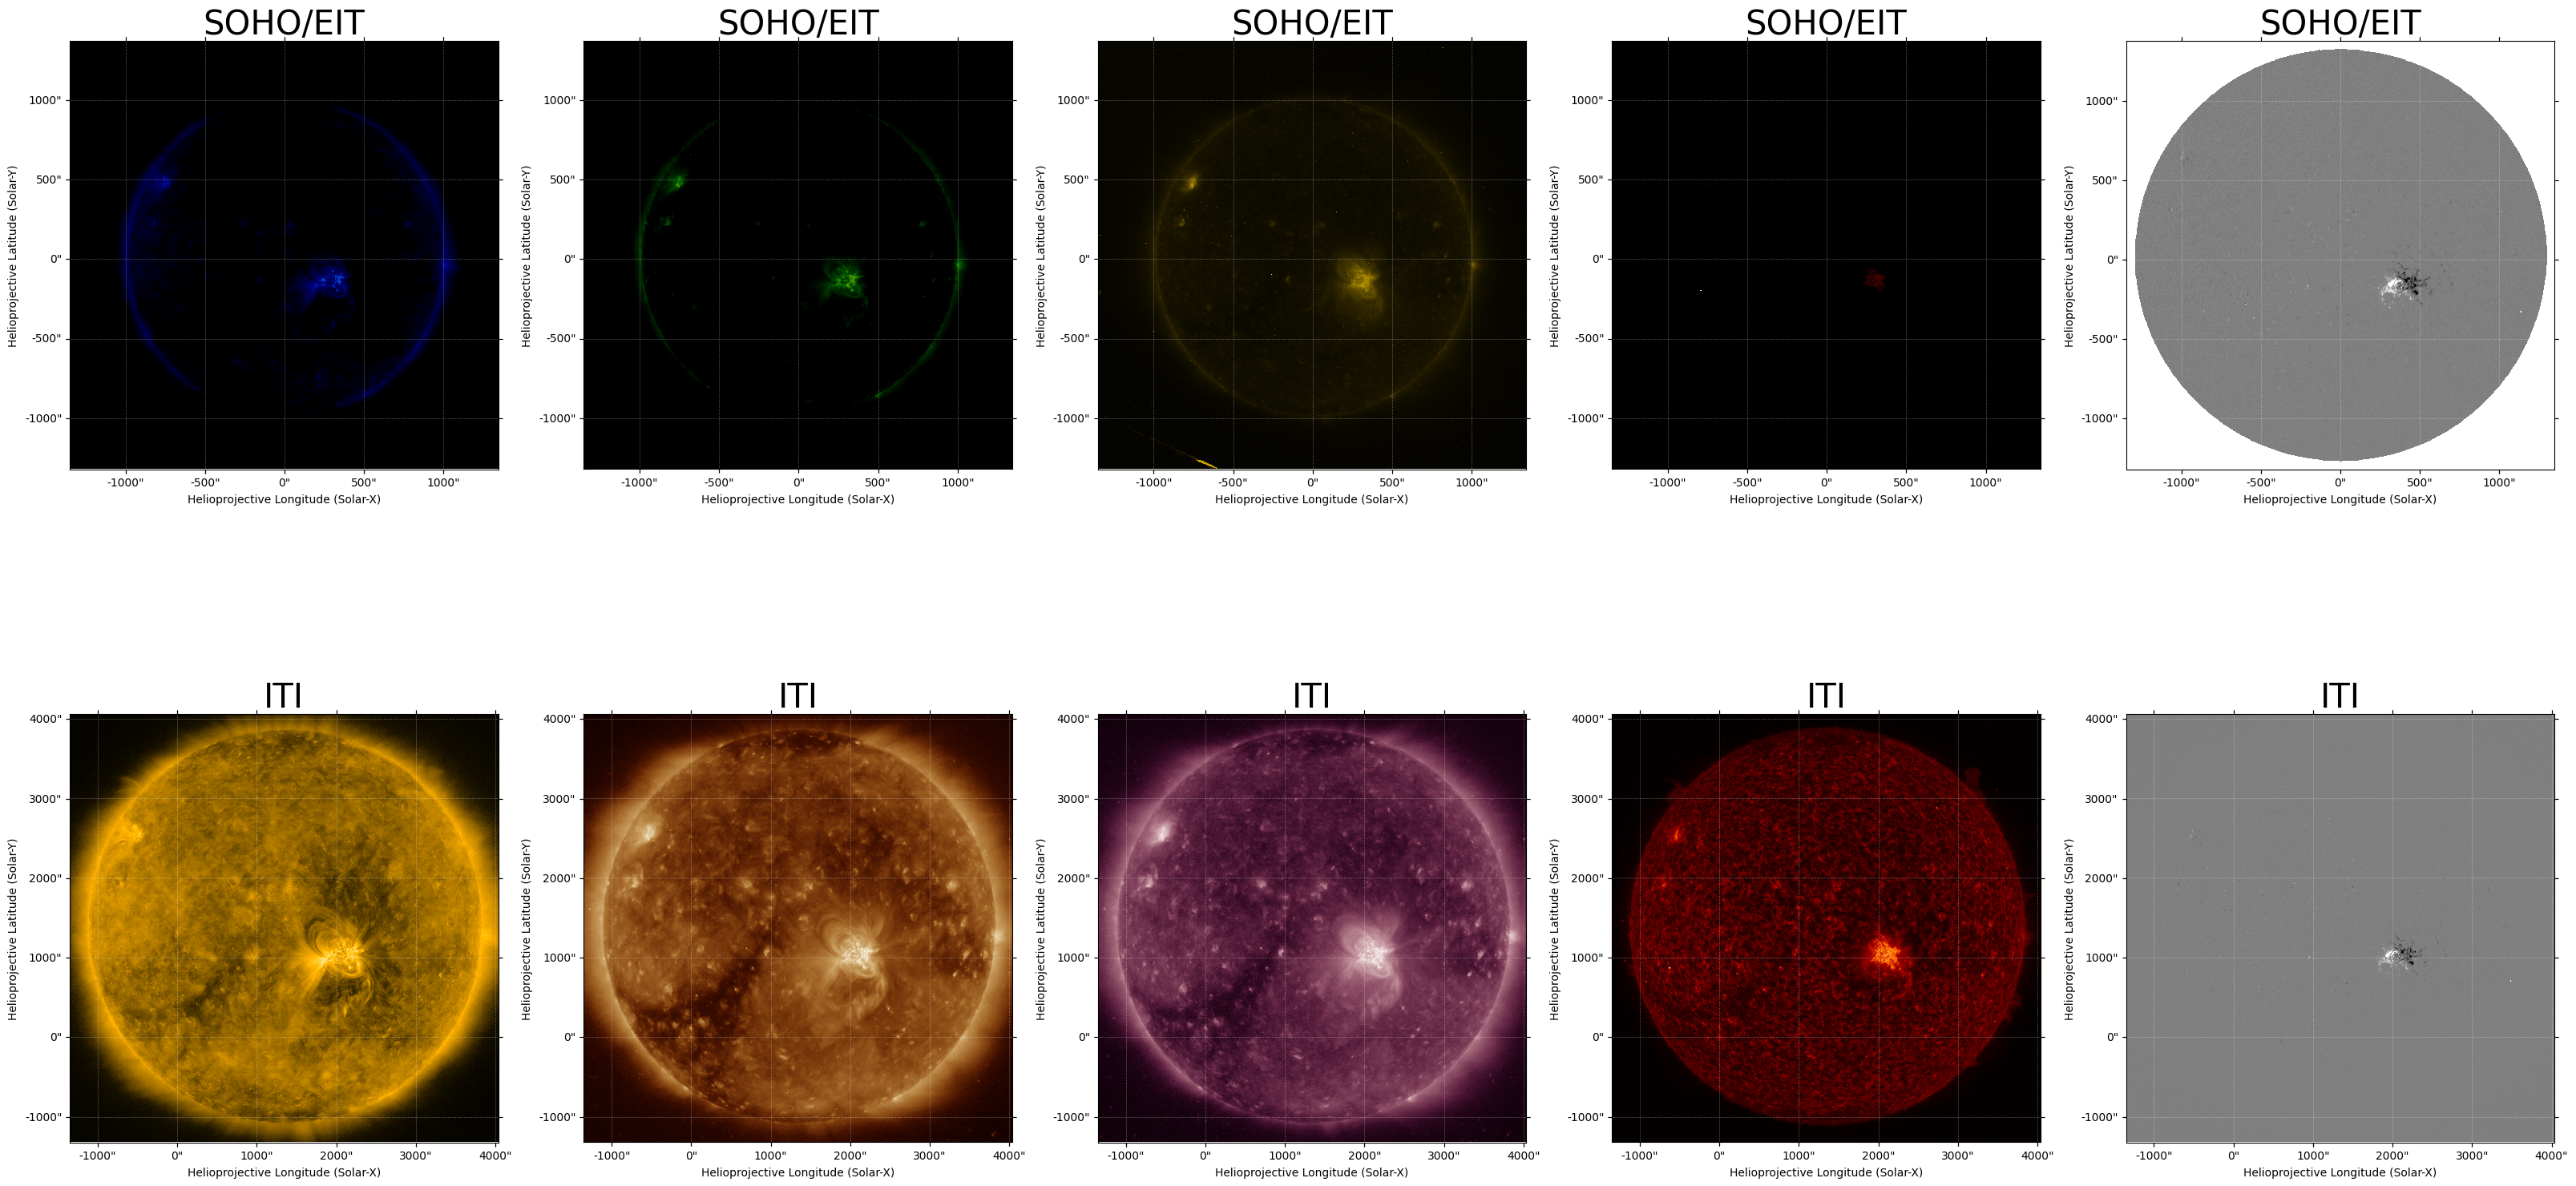

In [21]:
fig, axs = plt.subplots(2, 5, subplot_kw={'projection': soho_maps[0]}, figsize=(40, 20), dpi=100)
for i, (soho_map, iti_map) in enumerate(zip(soho_maps, iti_soho_maps)):
    soho_map.plot(axes=axs[0, i])
    iti_map.plot(axes=axs[1, i])
    axs[0, i].set_title('SOHO/EIT', fontsize=30)
    axs[1, i].set_title('ITI', fontsize=30)
plt.show()

The instruments have a different default colormap and scaling. For the comparison of the active region close to the center, we use the SDO colormaps and normalization (asinh).

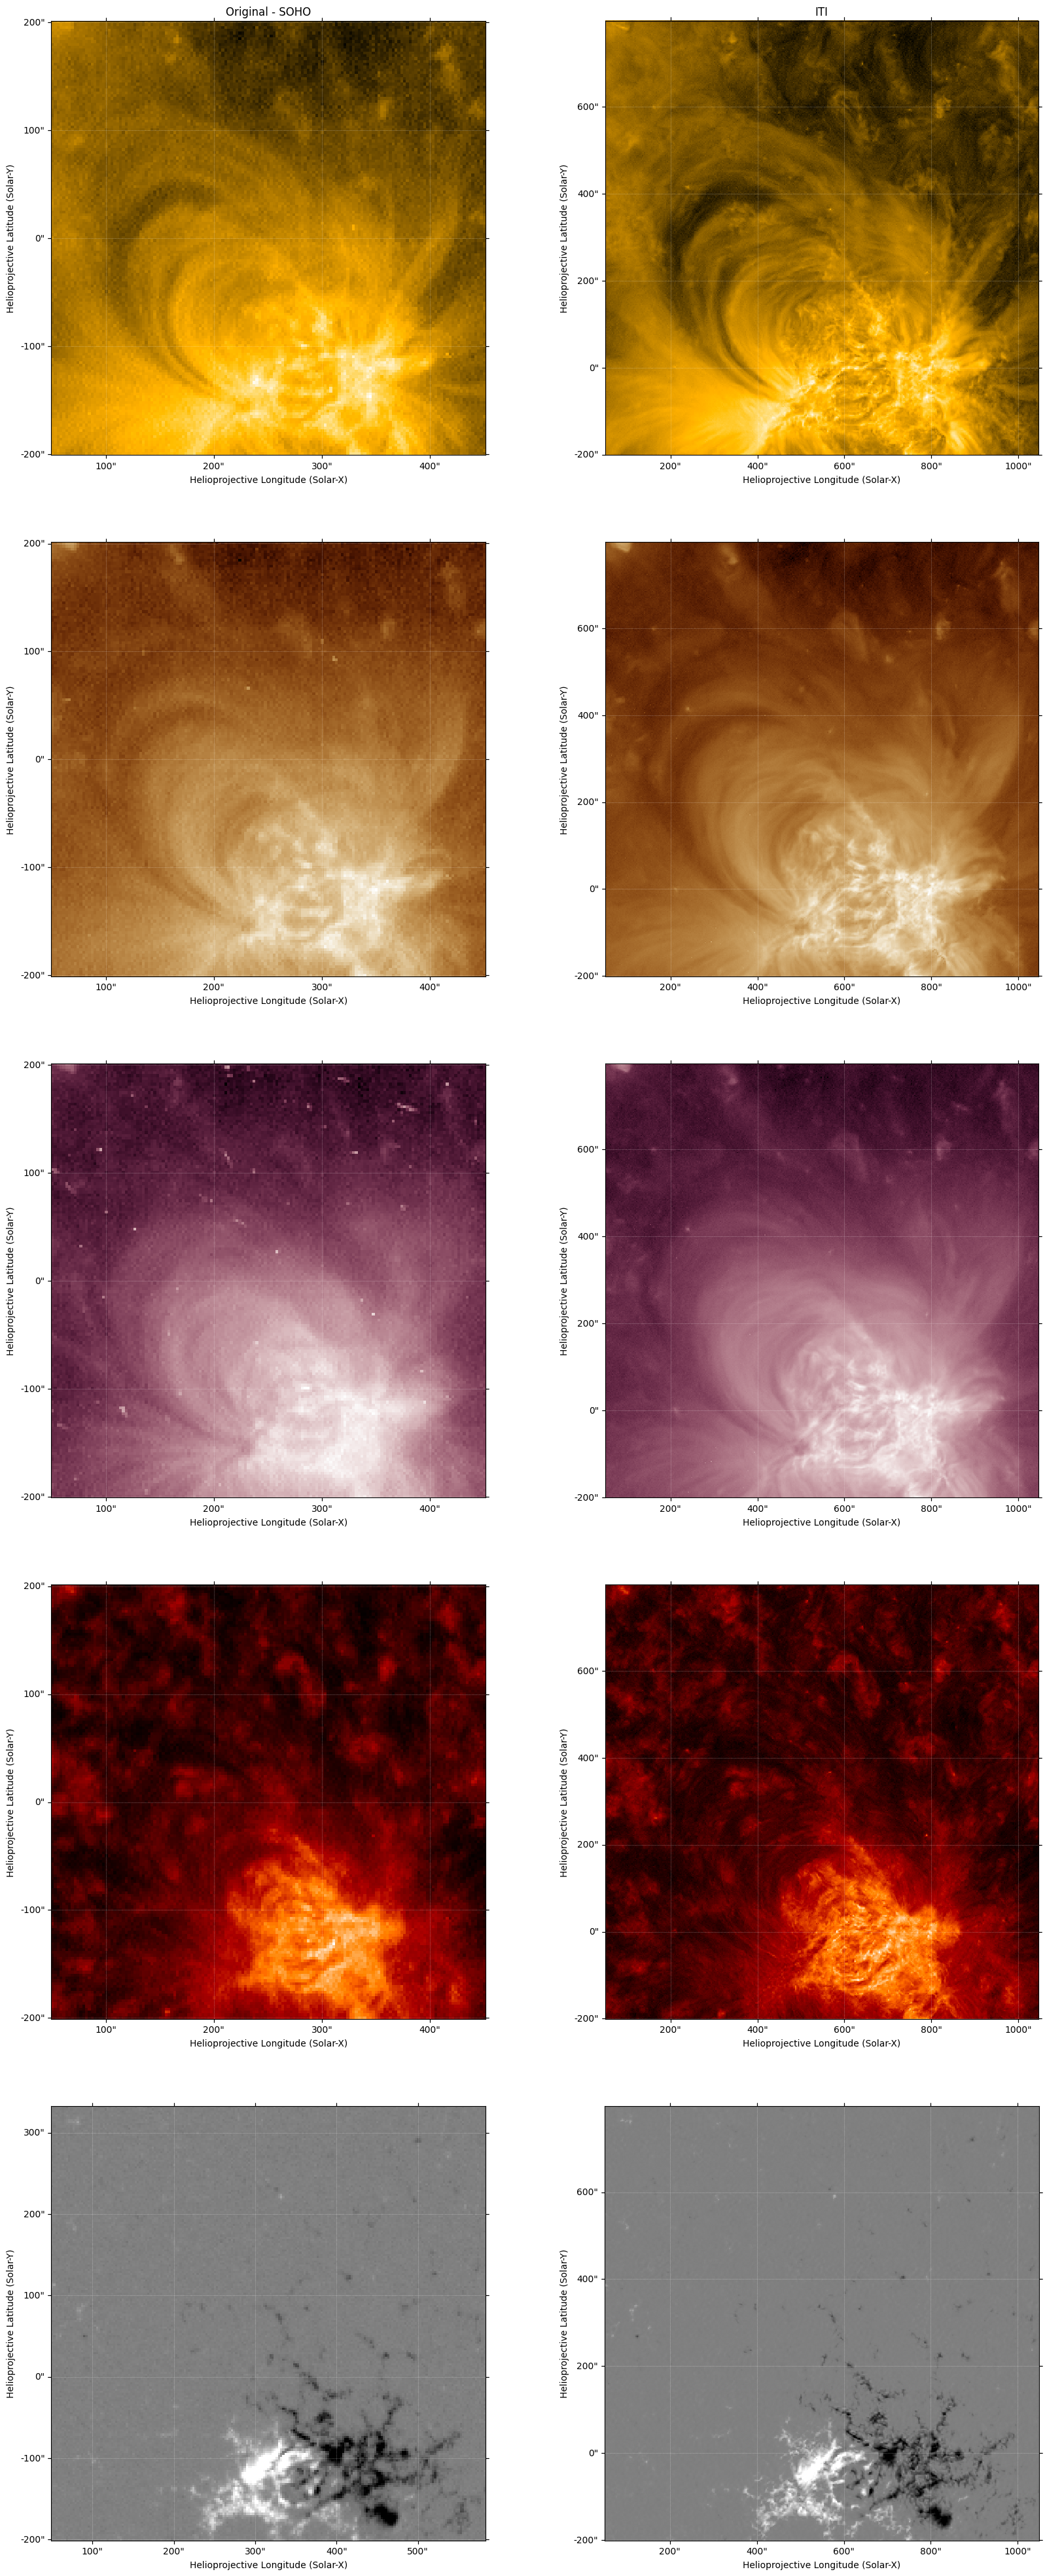

In [24]:
bl = SkyCoord(50 * u.arcsec, -200 * u.arcsec, frame=soho_maps[0].coordinate_frame)
tr = SkyCoord(450 * u.arcsec, 200 * u.arcsec, frame=soho_maps[0].coordinate_frame)

fig, axs = plt.subplots(5, 2, figsize=(20, 50), dpi=100, subplot_kw={'projection': soho_maps[0].submap(bl, top_right=tr)})
for i, (soho_map, iti_map) in enumerate(zip(soho_maps, iti_soho_maps)):
    soho_map.submap(bl, top_right=tr).plot(axes=axs[i,0], **iti_map.plot_settings)
    iti_map.submap(bl, top_right=tr).plot(axes=axs[i,1], **iti_map.plot_settings)
[ax.set_title('') for ax in np.ravel(axs)]
axs[0,0].set_title('Original - SOHO')
axs[0,1].set_title('ITI')
plt.show()
plt.close()